In [1]:
import os
import pandas as pd
import janitor
import numpy as np
import ast
from tqdm.notebook import tqdm
from pranaam import pranaam
from outkast import secc_caste
from naampy import predict_fn_gender
import gc
import warnings
warnings.filterwarnings('ignore')
import telegram_send

LF_FP = '../../toi-lf/ner'
filelist = os.listdir(LF_FP)
yearly_datafiles = [filename for filename in filelist if filename.endswith(".csv.gz")]
yearly_datafiles[:5]

['toi_ner_1838.csv.gz',
 'toi_ner_1839.csv.gz',
 'toi_ner_1840.csv.gz',
 'toi_ner_1841.csv.gz',
 'toi_ner_1842.csv.gz']

In [2]:
# (fold cell)Helper functions for minority dist.
def person_from_nerlist(dataframe, nercol='ner'):
    """
    Take the dataframe with column of list of ner tuples (eg [('26', 'CARDINAL'), ('Indranil Basu TNN', 'PE...)
    and return a dataframe with a column of persons and last names.
    """
    _df = (dataframe.copy()
           .add_column('persons', '')
          )
    for ix, row in _df.iterrows():
        persons = row['persons']
        if persons!='':
            continue
        else:
            persons = []

        ners = row['ner']
        ners = ast.literal_eval(ners)
        for ner in ners:
            entity, entitytype = ner
            if entitytype.lower()=="person":    
                persons.append(entity)

        _df.at[ix, 'persons'] = persons
    
    _df = (_df
           .remove_columns(nercol)
           .explode(column='persons')
           .assign(last=lambda df: df.persons.apply(lambda x: str(x).split(' ')[-1]))
           .dropna(subset='persons')
          )    
    return _df

def get_muslim_dist(dataframe, personcol='persons'):
    """
    Get distribution of muslims using pranaam.
    """
    namelist = dataframe.drop_duplicates(personcol)[personcol].tolist()
    dataframe = (dataframe
                 .merge((pranaam.pred_rel(namelist).dropna(subset='pred_label')), 
                        how='left', left_on=personcol, right_on='name', validate='m:1')
                 .dropna(subset='pred_label')
                )    
    dist = len(dataframe.query('pred_label=="muslim"'))/len(dataframe)    
    return dist

def get_caste_dist(dataframe, lastnamecol='last'):
    """
    Get distribution of castes (sc, st, others) using outkast.
    """
    dataframe = (dataframe
                 .merge((secc_caste(dataframe.drop_duplicates(lastnamecol), lastnamecol)
                         .filter([lastnamecol, 'n_sc', 'n_st', 'n_other', 'prop_sc', 'prop_st','prop_other'])
                   ), 
                   how='left', on=lastnamecol, validate='m:1')
                 .assign(pred_caste=lambda df: df[['prop_sc', 'prop_st', 'prop_other']].idxmax(axis=1))
                 .dropna(subset='pred_caste')
                )    
    npred = len(dataframe)
    nsc = len(dataframe.query('pred_caste=="prop_sc"')) 
    nst = len(dataframe.query('pred_caste=="prop_st"')) 
    nstsc = len(dataframe.query('pred_caste=="prop_st"|pred_caste=="prop_sc"')) 
    
    dist_sc = nsc/npred
    dist_st = nst/npred
    dist_stsc = nstsc/npred
    return dist_sc, dist_st, dist_stsc

def get_women_dist(dataframe, personcol='persons'):
    """
    Get distribution of women using naampy.
    """
    personslist = dataframe[personcol].dropna().tolist()
    _df = (dataframe.merge((predict_fn_gender(personslist)
                            .drop_duplicates(subset='name')
                            .dropna(subset='pred_gender')
                           ), 
                           left_on=personcol, right_on='name', how='left', validate='m:1')
          )
    _df = _df.dropna(subset='pred_gender')
    women_dist = len(_df.query('pred_gender=="female"'))/len(_df)
    return women_dist

In [4]:
payload_dict = {}
for filename in tqdm(yearly_datafiles):
    year = filename.split('_')[2].split('.')[0]
    df = pd.read_csv(os.path.join(LF_FP, filename), usecols=['ner'])
    if len(df)==0: 
        payload_dict[year] = [0, 0, np.nan, np.nan, np.nan, np.nan, np.nan] 
        del df
        gc.collect()
    else:
        df_persons = person_from_nerlist(df)
        narticles, npersons = len(df), len(df_persons)

        muslim_dist = get_muslim_dist(df_persons)    
        dist_sc, dist_st, dist_stsc = get_caste_dist(df_persons)
        women_dist = get_women_dist(df_persons)

        del df, df_persons
        gc.collect()

        payload_dict[year] = [narticles, npersons, muslim_dist, dist_sc, dist_st, dist_stsc, women_dist]

  0%|          | 0/171 [00:00<?, ?it/s]

Model path D:\ProgramData\Anaconda3\lib\site-packages\pranaam\model


In [5]:
# telegram_send.send(messages=[f"TOI year parsing completed"])     

[4178]

In [8]:
colnames = ['narticles', 'npersons', 'muslim_dist', 'dist_sc', 'dist_st', 'dist_stsc', 'women_dist']
df_out = pd.DataFrame.from_dict(payload_dict, orient='index', columns=colnames)
df_out.to_csv('../data/toi_yearly_minority_dist.csv')
df_out

,narticles,npersons,muslim_dist,dist_sc,dist_st,dist_stsc,women_dist
1838,768,8262,0.046115,0.007126,0.064133,0.071259,0.290448
1839,4911,53514,0.055313,0.020194,0.146204,0.166397,0.355715
1840,5186,54022,0.053441,0.024977,0.139685,0.164662,0.368007
1841,5029,63760,0.057842,0.027051,0.222077,0.249127,0.391339
1842,5216,70015,0.058416,0.019980,0.181172,0.201151,0.367358
...,...,...,...,...,...,...,...
2004,71408,393313,0.066652,0.034775,0.017917,0.052692,0.334882
2005,92458,513775,0.067082,0.039112,0.015735,0.054848,0.304835
2006,100581,553536,0.070039,0.038074,0.017461,0.055535,0.332305
2007,101360,569581,0.067372,0.037172,0.016970,0.054142,0.286977


<AxesSubplot:>

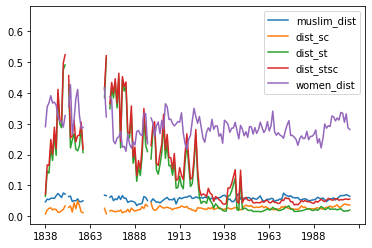

In [7]:
df_out[['muslim_dist', 'dist_sc', 'dist_st', 'dist_stsc', 'women_dist']].plot()